In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [9]:
class COVID19GeoSpatialModel:
    def __init__(self, initial_infected):
        self.grid_size = 3
        self.populations = np.array([[1000, 1200, 1400], 
                                     [1600, 1800, 2000], 
                                     [2200, 2400, 2600]])
        
        # SEIR initialization
        self.S = np.array(self.populations, dtype=np.float64)
        self.E = np.zeros_like(self.populations, dtype=np.float64)
        self.I = np.zeros_like(self.populations, dtype=np.float64)
        self.R = np.zeros_like(self.populations, dtype=np.float64)

        self.I[initial_infected] = 1  
        self.S[initial_infected] -= 1  
        self.activity_rates = np.full((self.grid_size, self.grid_size), 1.0)  # all activity rates set to 1
        self.epsilon = 0.5
        self.q_base = 0.3
        self.q_i = np.full((self.grid_size, self.grid_size), self.q_base)
        self.alpha = 0.2  # Rate of exposed individuals becoming infectious
        self.gamma = 0.1  # Recovery rate of infectious individuals

    def calculate_activity_weighted_sum(self):
        return np.sum(self.activity_rates * self.populations)
    
    def calculate_transmission_rate(self, i, j):
        # returns the transmission rate from I to J
        if i != j:
            beta_ij = (1 - self.epsilon) * self.q_i[j[0], j[1]] * (self.activity_rates[i[0], i[1]] * self.I[i[0], i[1]]) / self.populations[j[0], j[1]]
        else:
            beta_ij = (self.epsilon * self.q_i[i[0], i[1]] * self.I[i[0], i[1]]) / self.populations[i[0], i[1]]
        return beta_ij
    
    def update_SEIR_states(self):
        new_exposures = np.zeros_like(self.S)
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]  # Up, down, left, right neighbors
                new_exposures[i, j] = 0
                for nb in neighbors:
                    if 0 <= nb[0] < self.grid_size and 0 <= nb[1] < self.grid_size:
                        intracell_beta = self.calculate_transmission_rate((i, j), nb) 
                        # QUESTION: How to calculate the new exposed (or should it be infecteds?) from the beta_i<j?
                intercell_beta = self.calculate_transmission_rate((i, j), (i, j))
                
        
        # Update S, E, I, R
        newE_to_I = self.alpha * self.E
        newI_to_R = self.gamma * self.I
        
        self.S = self.S.astype(float) - new_exposures
        self.E = self.E.astype(float) + new_exposures.astype(float) - newE_to_I
        self.I = self.I.astype(float) + newE_to_I - newI_to_R
        self.R = self.R.astype(float) + newI_to_R
    
    def run_simulation(self, time_steps):
        for _ in range(time_steps):
            self.update_SEIR_states()
        
        # Display final states after simulation
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
        compartments = [(self.S, 'Susceptible'), (self.E, 'Exposed'), (self.I, 'Infected'), (self.R, 'Recovered')]
        
        for ax, (compartment, title) in zip(axes.flatten(), compartments):
            sns.heatmap(compartment, ax=ax, annot=True, fmt=".1f", cmap="viridis")
            ax.set_title(title)
        
        plt.tight_layout()
        plt.show()

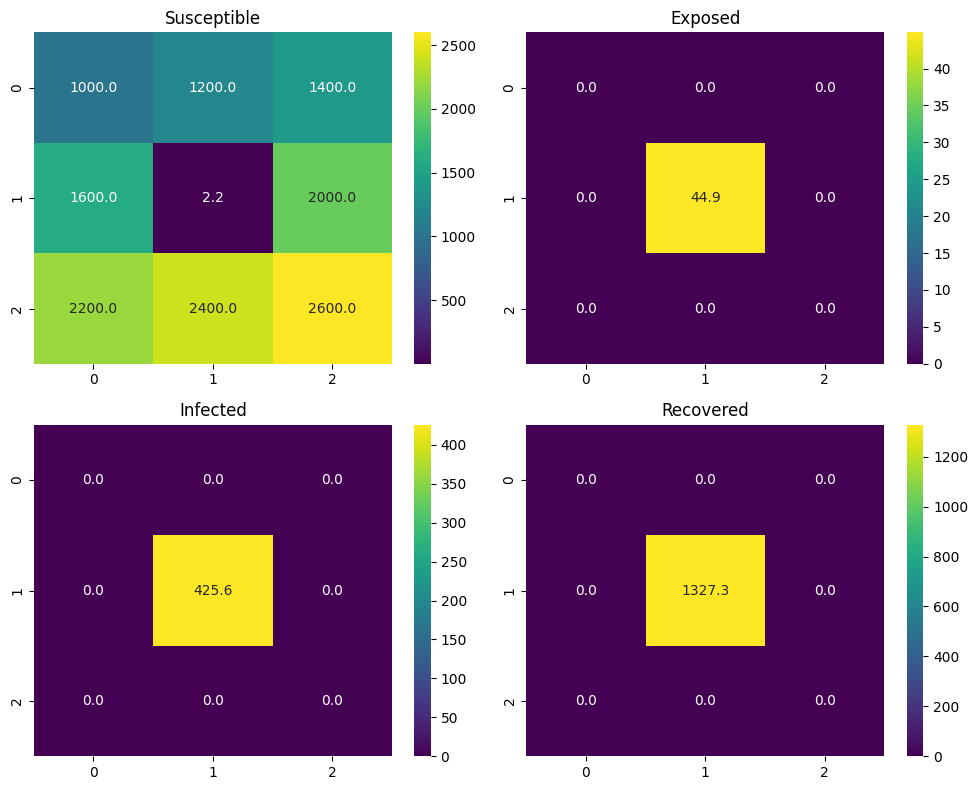

In [10]:
# Initialize the model with one infected individual in the center cell (1, 1)
initial_infected = (1, 1)
model = COVID19GeoSpatialModel(initial_infected)

# Run the simulation
time_steps = 50
model.run_simulation(time_steps)